In [80]:
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
# set as seaborn’s default theme
sns.set_theme()
import glob     
import numpy as np
from PIL import Image
from collections import Counter
import os
import shutil


# Load the data path to images
IMG_DIR = '../data'

# We will assume that all images are of .jpg and .png extensions

In [81]:
def convert_all_images_from_png_to_jpg(IMG_DIR) -> None:
    """
    Converts all .png files to .jpg through PIL .convert("RGB")
    :param IMG_DIR: str

    """
    counter = 0 
    for path in glob.glob(f"{IMG_DIR}/*.png"):
            try:
                im = Image.open(path)
                rgb_im = im.convert("RGB")
                rgb_im.save(path.replace('.png','.jpg'))
                counter += 1
            except:
                print(f"Unable to convert image {path}")
    if counter > 0:
        print("Successfully converted all .png images")
    else:
        print("No .png images")

def build_train_df(IMG_DIR):
    train_labels_df = pd.read_csv(f"{IMG_DIR}/test_labels.csv")
    train_data_df = pd.DataFrame([path.replace(f"{IMG_DIR}\\","") for path in glob.glob(f"{IMG_DIR}/*.jpg")],columns=['image'])
    train_df = pd.merge(train_labels_df, train_data_df, how ='inner', on =['image'])
    return train_df



In [124]:
convert_all_images_from_png_to_jpg(IMG_DIR)

train_df = build_train_df(IMG_DIR)
print(train_df)
CLASSES = list(train_df.category.unique())
print("Classes:", CLASSES)


No .png images
           image  category
0    2810798.jpg         0
1    2818929.jpg         0
2    2856024.jpg         0
3    2878219.jpg         0
4    2841647.jpg         0
..           ...       ...
995  2835366.jpg         4
996  2792391.jpg         4
997  2902617.jpg         4
998  2894578.jpg         4
999  2900652.jpg         4

[1000 rows x 2 columns]
Classes: [0, 1, 2, 3, 4]


In [130]:
def process_data(train_df,dir,classes):
    """
    Checks if the data is in the correct format for torchvision's ImageFolder

    """
    img_dir_folders = next(os.walk(f"{dir}/processed_data/"))[1]
    classes = [str(i) for i in classes]
    # Create image label key pair {'2810798.jpg': 0, '2818929.jpg': 0}

    train_dic = train_df.set_index('image').to_dict()['category']
    print(set(img_dir_folders),set(classes))
    if set(img_dir_folders) != set(classes):
        for j in classes:
                if j not in img_dir_folders:
                        os.makedirs(dir+f"/processed_data/{j}", exist_ok=False)
                for img_n in train_df.loc[train_df.category == int(j)].image:
                        try:
                                shutil.copy(src=f"{IMG_DIR}/{img_n}", dst=f"{IMG_DIR}/processed_data/{train_dic[img_n]}/{img_n}")
                        except KeyError:
                                print(f"Unable to copy {img_n}")

In [141]:
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchsummary import summary
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split
import torch


# We want to ensure that our validation dataset has the same distribution as our trainin dataset
# As such we will build a sampler for pytorch's dataloader
def stratified_random_shuffle_sampler(train_dataset,test_size=0.3,shuffle=True):
    train_idx, valid_idx= train_test_split(
                                            np.arange(len(train_dataset.targets)),
                                            test_size=test_size,
                                            shuffle=shuffle,
                                            stratify=train_dataset.targets
                                            )
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    return train_sampler, valid_sampler
    


In [159]:
# For using our pre-trained model VGG16, we need to ensure that we use the exact same pre-processing steps
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# We will process our data to ensure that the file format is appopropriate for pytorch's ImageFolder
process_data(train_df,IMG_DIR,CLASSES)

PROCESSED_DATA_PATH = f"{IMG_DIR}/processed_data/"
BATCH_SIZE = 32

# Load the training and validation dataset
train_dataset = datasets.ImageFolder(PROCESSED_DATA_PATH, transform=transform)
print(train_dataset)

# randomly split train and validation data, we could also do a simple splice of 0.5 train - 0.5 validate. 
train_sampler, valid_sampler = stratified_random_shuffle_sampler(train_dataset, test_size=0.3, shuffle=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, \
                              sampler=train_sampler)
valid_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, \
                              sampler=valid_sampler)
train_size =  len(train_sampler)
valid_size = len(valid_sampler)


{'0', '3', '4', '1', '2'} {'0', '3', '4', '1', '2'}
Dataset ImageFolder
    Number of datapoints: 1000
    Root location: ../data/processed_data/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               RandomAffine(degrees=[-40.0, 40.0], scale=(1, 2), shear=[-15.0, 15.0])
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


C:\Users\cawin\AppData\Roaming\Python\Python38\site-packages\torchvision\transforms\transforms.py:1420: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  warnings.warn(
C:\Users\cawin\AppData\Roaming\Python\Python38\site-packages\torchvision\transforms\transforms.py:1435: UserWarning: The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. Please use 'fill' instead.
  warnings.warn(


c:\Users\cawin\anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


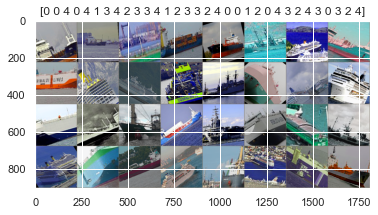

In [160]:
import torchvision
# Sample some of our training data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out,title=classes.numpy())

# Import and train model

In [197]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = models.vgg16(pretrained=True)
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [200]:
num_ftrs = model_ft.classifier[-4].out_features
# Here the size of each output sample is set to 5
model_ft.classifier[-1] = nn.Linear(num_ftrs, len(CLASSES))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# We will use ADAM as our opitimiser to learn the optimal amount of gradient descent
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
# Exponentially Decay LR by a factor of 0.1
exp_lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.1)

In [201]:
import time
import copy
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.perf_counter()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in train_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / train_size
            epoch_acc = running_corrects.double() / train_size
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [202]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
